# Experiment Meta

In [1]:
import sys, time
from pathlib import Path

In [2]:
sys.path.append('..')

In [3]:
DATA_ROOT = Path('../data')
RESULTS_ROOT = Path('./results')
EXP_DIR = RESULTS_ROOT / 'self_play_proto_0_control'
EXP_DIR.mkdir(exist_ok=True)
assert not len(list(EXP_DIR.iterdir()))

# Experiment Setup

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import seaborn as sns; sns.set(rc={'figure.figsize':(7,7)})

import gym

from tqdm.notebook import tqdm

import autotrain

import autotrain.envs.utils as utils
from autotrain.envs import AutoTrainEnvironment, Clf, ClfEngine
from autotrain.envs.thresholdout import Thresholdout

import autotrain.agent.A2C.train as train
import autotrain.agent.A2C.buffer as buffer

In [5]:
from functools import partial

In [6]:
DEVICE = torch.device("cuda:4")

In [7]:
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def reduceds(ds, pct_cap, no_signal=False):
    X, Y = ds.data, ds.targets
    
    if pct_cap:
        cap = int(pct_cap*len(X))
        X, Y = X[:cap], Y[:cap]
        
    
    if no_signal:
        print('suffling labels')
        np.random.shuffle(Y)
    
    ds.data, ds.targets = X, Y

def get_dataset(tfms, no_signal=False, pct_cap=None):
    train = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=True,
                                        download=True, transform=tfms)

    holdout = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=False,
                                           download=True, transform=tfms)
        
    # train.data, train.targets = train.data.numpy(),train.targets.numpy()
    # holdout.data, holdout.targets = holdout.data.numpy(),  holdout.targets.numpy()
    
    reduceds(train, pct_cap, no_signal)
    
    print(f'length of trainset: [{len(train)}]; len of holdout: [{len(holdout)}]')
    
    return train, holdout


In [8]:
TFMS = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trnds, valds = get_dataset(TFMS, pct_cap=0.2)

Files already downloaded and verified
Files already downloaded and verified
length of trainset: [10000]; len of holdout: [10000]


In [9]:
def accuracy(data: torch.utils.data.DataLoader, model: nn.Module): # phi
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(data,total=len(data)):
            images, labels = batch[0].to(DEVICE), batch[1]
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

## Model

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1) # 1->3 for CIFAR
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, len(CLASSES))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [11]:
model = Classifier()

## Baseline

In [12]:
"""
model, trnds, valds, phi: callable,
criterion: callable = nn.CrossEntropyLoss(), opt: callable = optim.SGD,
lr_init=3e-4, bs_init=16, max_lr=3, dev=None, v=False
"""

baseline = ClfEngine(Classifier(), trnds, valds, accuracy, dev=DEVICE, v=True, opt=optim.SGD)

In [13]:
baseline.clf()

Clf(history=array([], shape=(3, 0), dtype=float64), result=array([], dtype=float64))

In [14]:
baseline.do_updates(len(baseline.trndl) * 3)

[clf_engine]  training loop: started for [1875] updates; BS=[16] LR=[0.0003]!



[clf_engine]  training loop: started for [1250] updates; BS=[16] LR=[0.0003]!



[clf_engine]  training loop: started for [625] updates; BS=[16] LR=[0.0003]!



[clf_engine]  training loop: done!


In [15]:
baseline.optim_step

1875

In [16]:
baseline.result += [baseline.test()]

In [17]:
baseline_clf=baseline.clf()

In [18]:
baseline_clf.history.shape, baseline_clf.result

((3, 1875), array([0.17298009]))

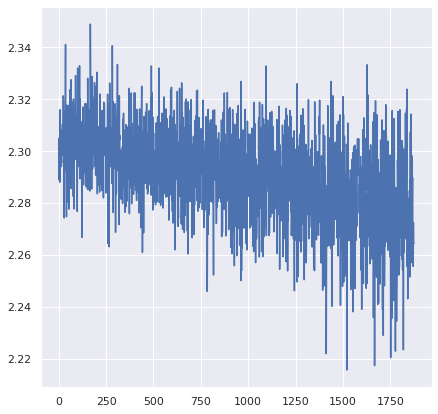

In [19]:
sns.lineplot(x=range(len(baseline_clf.history[0])), y=baseline_clf.history[0])

## Env

In [20]:
U = 30
horizon = 500

BPE = len(trnds) // 16

In [21]:
(U*horizon )// BPE

24

In [22]:
ate = gym.make('AutoTrain-v0')
ate.set_config()
ate.seed()

In [23]:
"""
baseline: Clf, competitor: ClfEngine, savedir: Path,
U=30, horizon=50, step_reward=0.1, terminal_reward=10, update_penalty=0.1,
num_workers=4, v=False, device=None
"""
_ = ate.init(baseline=baseline_clf,  
         competitor=ClfEngine(Classifier(),trnds, valds, accuracy, dev=DEVICE, v=True, opt=optim.Adam), 
         savedir=EXP_DIR, U=30, horizon=500, device=DEVICE, v=True, o_dim=(256, 256))

/home/jupyter-skenjeye@broadinst-05974/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[ATE:0]  environment initialised : <autotrain.envs.autotrain_env.AutoTrainEnvironment object at 0x7f206a269e48>


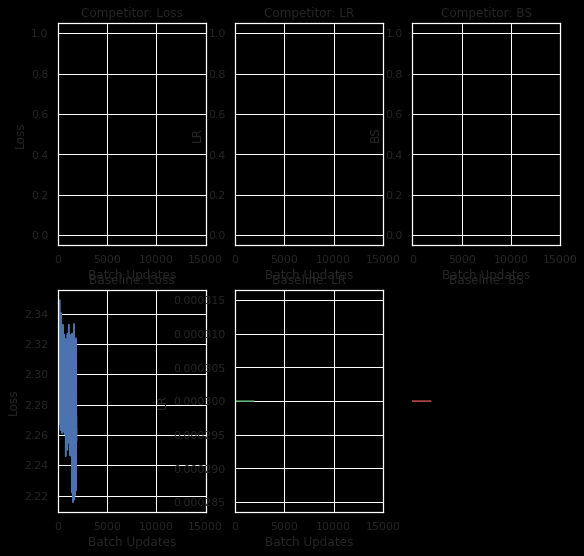

In [24]:
fg = ate.render()

## Agent

env: AutoTrainEnvironment, state_shape: np.array, action_dim: int,
action_lim: np.array, ram, savedir: Path, bs=32, lr=3e-4, dev=None

In [25]:
MAX_EPISODES = 5000
MAX_STEPS = 1000
MAX_BUFFER = 1000000

S_DIM = ate.observation_space.shape
A_DIM = ate.action_space.shape[0]
A_MAX = ate.action_space.high

ram = buffer.MemoryBuffer(MAX_BUFFER)
trainer = train.Trainer(ate, S_DIM, A_DIM, A_MAX, ram, savedir=EXP_DIR, dev=DEVICE)

# Experiment Execution

## Agent Training Loop

In [ ]:
for ep in range(MAX_EPISODES):
    trainer.episode(ep)

[clf_engine]  re-init complete


/home/jupyter-skenjeye@broadinst-05974/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[ATE:0]  environment initialised : <autotrain.envs.autotrain_env.AutoTrainEnvironment object at 0x7f206a269e48>
[ATE:0]  action [[5.49119406 4.45964535 0.48102459 0.46318691]] recieved
[clf_engine]  scaled BS by [5.491194062236879]; BS=[87]
[clf_engine]  scaled LR by [4.459645345222102]; LR=[0.0003]
[clf_engine]  training loop: started for [30] updates; BS=[87] LR=[0.0013378936035666304]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: done!
[ATE:1]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [2.8] seconds for one full step
[ATE:1]  action [[6.21227828 4.44903737 0.46051515 0.467367  ]] recieved
[clf_engine]  scaled BS by [6.212278279992162]; BS=[540]
[clf_engine]  scaled LR by [4.449037369222454]; LR=[0.0013378936035666304]
[clf_engine]  training loop: started for [30] updates; BS=[540] LR=[0.005952338638311631]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [11] updates; BS=[540] LR=[0.005952338638311631]!



[clf_engine]  training loop: done!
[ATE:2]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [3.7] seconds for one full step
[ATE:2]  action [[5.91248499 5.42701958 0.44621159 0.47471546]] recieved
[clf_engine]  scaled BS by [5.912484994616822]; BS=[1000]
[clf_engine]  scaled LR by [5.427019575178638]; LR=[0.005952338638311631]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[0.032303458308209375]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[0.032303458308209375]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[0.032303458308209375]!



[clf_engine]  training loop: done!
[ATE:3]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.1] seconds for one full step
[ATE:3]  action [[5.82110674 4.04387013 0.39335183 0.40268053]] recieved
[clf_engine]  scaled BS by [5.821106739637676]; BS=[1000]
[clf_engine]  scaled LR by [4.0438701293402035]; LR=[0.032303458308209375]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[0.1306309901269545]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[0.1306309901269545]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[0.1306309901269545]!



[clf_engine]  training loop: done!
[ATE:4]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.4] seconds for one full step
[ATE:4]  action [[5.56064632 3.64131048 0.4478666  0.39020179]] recieved
[clf_engine]  scaled BS by [5.560646322050125]; BS=[1000]
[clf_engine]  scaled LR by [3.6413104767452658]; LR=[0.1306309901269545]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[0.47566799293688683]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[0.47566799293688683]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[0.47566799293688683]!



[clf_engine]  training loop: done!
[ATE:5]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.3] seconds for one full step
[ATE:5]  action [[5.76207346 4.27156912 0.50442051 0.45465773]] recieved
[clf_engine]  scaled BS by [5.762073464592365]; BS=[1000]
[clf_engine]  scaled LR by [4.271569117898951]; LR=[0.47566799293688683]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[2.0318487090021824]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[2.0318487090021824]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[2.0318487090021824]!



[clf_engine]  training loop: done!
[ATE:6]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.1] seconds for one full step
[ATE:6]  action [[5.59496865 5.05371217 0.52793839 0.45330944]] recieved
[clf_engine]  scaled BS by [5.59496865055719]; BS=[1000]
[clf_engine]  scaled LR by [5.053712166864558]; LR=[2.0318487090021824]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:7]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.1] seconds for one full step
[ATE:7]  action [[5.02638726 4.96915607 0.42472212 0.48298333]] recieved
[clf_engine]  scaled BS by [5.0263872606305515]; BS=[1000]
[clf_engine]  scaled LR by [4.969156068570984]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:8]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.6] seconds for one full step
[ATE:8]  action [[4.90564395 5.28597888 0.42959251 0.4630781 ]] recieved
[clf_engine]  scaled BS by [4.905643950540613]; BS=[1000]
[clf_engine]  scaled LR by [5.28597888446276]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:9]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.4] seconds for one full step
[ATE:9]  action [[5.20236811 5.8445559  0.44658296 0.53969983]] recieved
[clf_engine]  scaled BS by [5.202368108644672]; BS=[1000]
[clf_engine]  scaled LR by [5.8445558950546665]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!



[ATE:10]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [8.2] seconds for one full step
[ATE:10]  action [[5.40260552 6.57534068 0.42927136 0.57595654]] recieved
[clf_engine]  scaled BS by [5.402605523620404]; BS=[1000]
[clf_engine]  scaled LR by [6.575340678642231]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:11]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.2] seconds for one full step
[ATE:11]  action [[5.53585658 6.17268672 0.3645252  0.52197069]] recieved
[clf_engine]  scaled BS by [5.5358565785822345]; BS=[1000]
[clf_engine]  scaled LR by [6.17268672412499]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:12]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.3] seconds for one full step
[ATE:12]  action [[5.75149103 5.85839353 0.38033423 0.5570552 ]] recieved
[clf_engine]  scaled BS by [5.751491028445698]; BS=[1000]
[clf_engine]  scaled LR by [5.858393531615675]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:13]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.1] seconds for one full step
[ATE:13]  action [[5.24663431 6.0464216  0.44803772 0.59897466]] recieved
[clf_engine]  scaled BS by [5.246634309016708]; BS=[1000]
[clf_engine]  scaled LR by [6.0464216033705345]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:14]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.1] seconds for one full step
[ATE:14]  action [[5.63507336 5.48648551 0.34710951 0.53679954]] recieved
[clf_engine]  scaled BS by [5.635073364760299]; BS=[1000]
[clf_engine]  scaled LR by [5.486485513114698]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:15]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.0] seconds for one full step
[ATE:15]  action [[5.31112025 5.14563376 0.37670288 0.49304836]] recieved
[clf_engine]  scaled BS by [5.311120245594948]; BS=[1000]
[clf_engine]  scaled LR by [5.145633755652356]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:16]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.1] seconds for one full step
[ATE:16]  action [[4.83404673 5.22085849 0.47679855 0.51641166]] recieved
[clf_engine]  scaled BS by [4.834046730771341]; BS=[1000]
[clf_engine]  scaled LR by [5.220858485718494]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:17]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.1] seconds for one full step
[ATE:17]  action [[3.69243505 6.6610788  0.4976998  0.50351046]] recieved
[clf_engine]  scaled BS by [3.6924350509574575]; BS=[1000]
[clf_engine]  scaled LR by [6.661078800642505]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:18]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.2] seconds for one full step
[ATE:18]  action [[3.40163817 6.11304624 0.56108249 0.50719498]] recieved
[clf_engine]  scaled BS by [3.401638166332108]; BS=[1000]
[clf_engine]  scaled LR by [6.11304624321006]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:19]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.3] seconds for one full step
[ATE:19]  action [[4.00112797 6.25725867 0.57401437 0.5745943 ]] recieved
[clf_engine]  scaled BS by [4.001127970061097]; BS=[1000]
[clf_engine]  scaled LR by [6.257258665494277]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!



[ATE:20]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [8.3] seconds for one full step
[ATE:20]  action [[4.78676408 6.64172235 0.60175651 0.61712796]] recieved
[clf_engine]  scaled BS by [4.786764076856583]; BS=[1000]
[clf_engine]  scaled LR by [6.6417223509084256]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:21]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.4] seconds for one full step
[ATE:21]  action [[5.16163834 6.67966383 0.56229995 0.67598494]] recieved
[clf_engine]  scaled BS by [5.161638335782978]; BS=[1000]
[clf_engine]  scaled LR by [6.679663834164973]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:22]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.5] seconds for one full step
[ATE:22]  action [[5.41258824 6.65568818 0.5684274  0.6503329 ]] recieved
[clf_engine]  scaled BS by [5.412588235006517]; BS=[1000]
[clf_engine]  scaled LR by [6.655688179632353]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:23]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.4] seconds for one full step
[ATE:23]  action [[4.84809387 6.18615201 0.54614745 0.54568252]] recieved
[clf_engine]  scaled BS by [4.848093868345315]; BS=[1000]
[clf_engine]  scaled LR by [6.186152007710585]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:24]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.0] seconds for one full step
[ATE:24]  action [[6.41638026 4.80291814 0.58969796 0.54218976]] recieved
[clf_engine]  scaled BS by [6.416380259129064]; BS=[1000]
[clf_engine]  scaled LR by [4.802918137483925]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:25]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.1] seconds for one full step
[ATE:25]  action [[5.65722782 5.85797135 0.60249795 0.60073829]] recieved
[clf_engine]  scaled BS by [5.65722782335609]; BS=[1000]
[clf_engine]  scaled LR by [5.857971350472781]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:26]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.1] seconds for one full step
[ATE:26]  action [[6.63046152 6.48977754 0.6481664  0.64408805]] recieved
[clf_engine]  scaled BS by [6.630461520146971]; BS=[1000]
[clf_engine]  scaled LR by [6.489777538942279]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:27]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.4] seconds for one full step
[ATE:27]  action [[6.12908926 6.07882825 0.6250167  0.64390874]] recieved
[clf_engine]  scaled BS by [6.129089262810258]; BS=[1000]
[clf_engine]  scaled LR by [6.0788282459426135]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:28]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.3] seconds for one full step
[ATE:28]  action [[6.0189335  6.45250548 0.60547908 0.65846498]] recieved
[clf_engine]  scaled BS by [6.018933503587252]; BS=[1000]
[clf_engine]  scaled LR by [6.452505480037297]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:29]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.0] seconds for one full step
[ATE:29]  action [[5.51586591 6.22666443 0.61959891 0.58898704]] recieved
[clf_engine]  scaled BS by [5.5158659073512695]; BS=[1000]
[clf_engine]  scaled LR by [6.2266644261243425]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!



[ATE:30]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [8.4] seconds for one full step
[ATE:30]  action [[6.12467424 6.12968069 0.60810281 0.51074327]] recieved
[clf_engine]  scaled BS by [6.124674236661937]; BS=[1000]
[clf_engine]  scaled LR by [6.1296806867822795]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:31]  reward at the end of time step is [-0.1]
[ATA episode 0]: took [5.4] seconds for one full step
[ATE:31]  action [[6.36606983 6.43567569 0.62727394 0.5174091 ]] recieved
[clf_engine]  scaled BS by [6.366069825041506]; BS=[1000]
[clf_engine]  scaled LR by [6.435675689766312]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:32]  reward at the end of time step is [-0.1]
[ATA] optimization step performed
[ATA episode 0]: took [5.3] seconds for one full step
[ATE:32]  action [[6.85660019 5.73798683 0.6452045  0.5421504 ]] recieved
[clf_engine]  scaled BS by [6.856600188244632]; BS=[1000]
[clf_engine]  scaled LR by [5.737986827422431]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:33]  reward at the end of time step is [-0.1]
[ATA] optimization step performed
[ATA episode 0]: took [5.7] seconds for one full step
[ATE:33]  action [[6.04405302 4.95772033 0.66154378 0.54648101]] recieved
[clf_engine]  scaled BS by [6.044053024438587]; BS=[1000]
[clf_engine]  scaled LR by [4.957720332908523]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:34]  reward at the end of time step is [-0.1]
[ATA] optimization step performed
[ATA episode 0]: took [5.4] seconds for one full step
[ATE:34]  action [[5.80039004 4.39764991 0.44982432 0.48687367]] recieved
[clf_engine]  scaled BS by [5.800390043556095]; BS=[1000]
[clf_engine]  scaled LR by [4.3976499135323674]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:35]  reward at the end of time step is [-0.1]
[ATA] optimization step performed
[ATA episode 0]: took [5.7] seconds for one full step
[ATE:35]  action [[4.85779774 4.3510224  0.40402765 0.50726524]] recieved
[clf_engine]  scaled BS by [4.857797744115304]; BS=[1000]
[clf_engine]  scaled LR by [4.351022395133979]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:36]  reward at the end of time step is [-0.1]
[ATA] optimization step performed
[ATA episode 0]: took [5.7] seconds for one full step
[ATE:36]  action [[4.32449212 4.17907146 0.33343561 0.55203108]] recieved
[clf_engine]  scaled BS by [4.324492116776367]; BS=[1000]
[clf_engine]  scaled LR by [4.179071455259887]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



[clf_engine]  training loop: started for [20] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: started for [10] updates; BS=[1000] LR=[3]!



[clf_engine]  training loop: done!
[ATE:37]  reward at the end of time step is [-0.1]
[ATA] optimization step performed
[ATA episode 0]: took [5.8] seconds for one full step
[ATE:37]  action [[4.973848   4.18716855 0.38612625 0.61430245]] recieved
[clf_engine]  scaled BS by [4.9738479964870494]; BS=[1000]
[clf_engine]  scaled LR by [4.187168550300326]; LR=[3]
[clf_engine]  training loop: started for [30] updates; BS=[1000] LR=[3]!


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
